In [2]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

### Explore the dataset


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1455 entries, 2013-01-01 to 2016-12-31
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   transactions  1455 non-null   int64
dtypes: int64(1)
memory usage: 22.7 KB


<Axes: xlabel='date'>

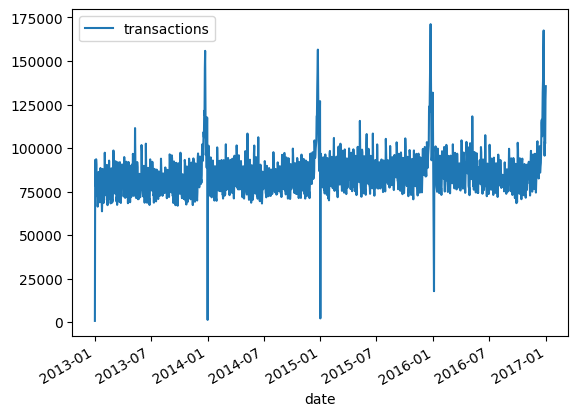

In [3]:
# Load the data files
df = pd.read_csv('train.csv')

df = df.set_index('date')
df.index = pd.to_datetime(df.index, format='%d-%m-%Y')

df.info()
df.plot()

## Check for stationarity of time series

Stationary data is a type of time series data where the statistical properties do not change over time:
- Constant Mean (The average value stays the same over time)
- Constant Variance (The spread or variability of the data remains the same over time.)
- No Seasonality or Trends (The data does not show regular patterns (seasonality) or long-term increases or decreases (trends))

Why is Stationary Data Important?
- Predictability: It is easier to predict and model because its statistical properties are stable.
- Model Assumptions: Many statistical and machine learning models assume the data is stationary.

### Calculate rolling statistics

#### Rolling mean
Rolling mean (or moving average) is the average of a set number of recent data points in a time series. It moves along with the data, updating the average as new data points come in.

Dataset for 10 days: [100, 120, 130, 90, 110, 115, 105, 125, 130, 140]

A 3-day rolling mean would be: 
- for Day 3: (100 + 120 + 130) / 3 = 116.67
- for Day 4: (120 + 130 + 90) / 3 = 113.33

#### Rolling standard deviation

Rolling standard deviation measures how spread out the recent data points are from their rolling mean, over a set number of data points. It moves along with the data, updating as new data points come in.

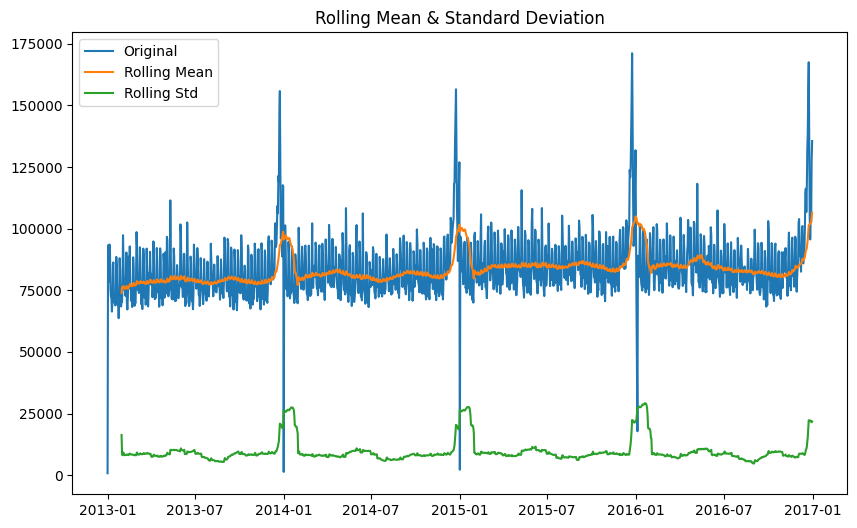

In [4]:
# Calculate rolling statistics
rolling_mean = df['transactions'].rolling(window=30).mean()
rolling_std = df['transactions'].rolling(window=30).std()

plt.figure(figsize=(10, 6))
plt.plot(df['transactions'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

### ACF & PACF

#### ACF
ACF (Autocorrelation Function) measures how a time series is correlated with itself at different time lags.

Time Lag
- A time lag is a shift in the data. For example, if you have daily sales data, a lag of 1 means you compare today’s sales with yesterday’s sales, a lag of 2 means you compare today’s sales with the sales from two days ago, and so on.

Correlation
- Correlation is a measure of the relationship between two sets of data. A high correlation means the data sets move similarly.

Interpreting ACF for Stationarity
- For stationary data, the ACF values typically decrease rapidly, approaching zero relatively quickly
- For non-stationary data, the ACF values decrease slowly and can remain significant for many lags

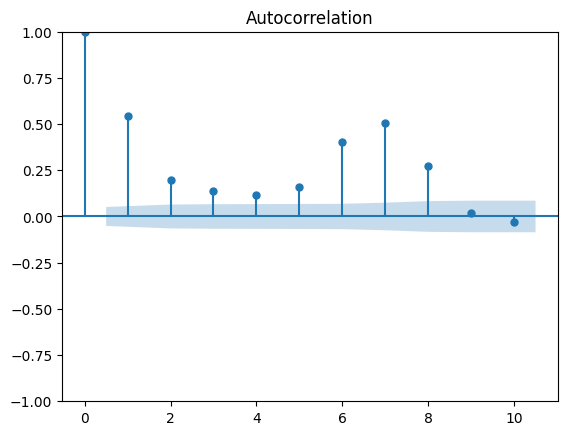

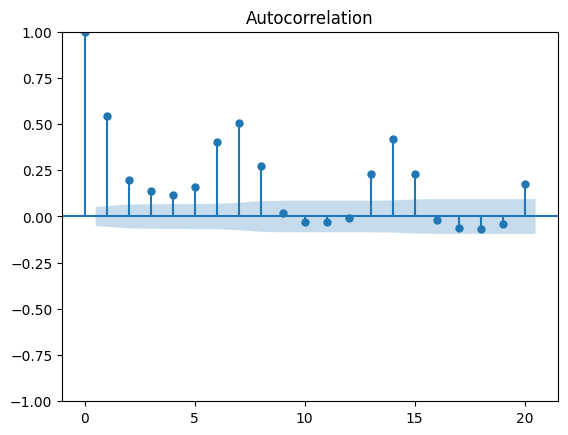

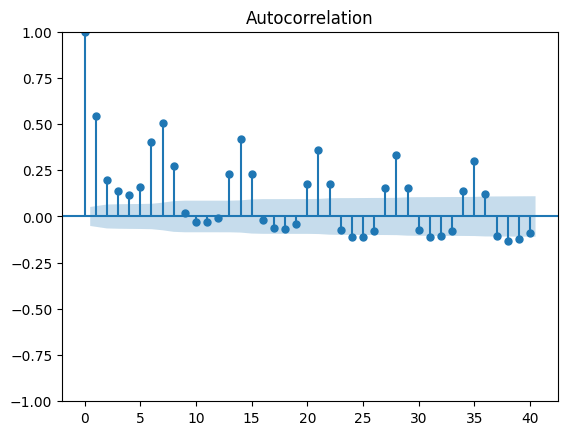

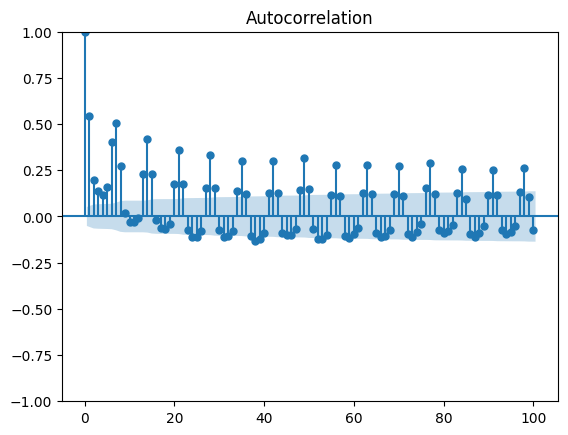

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_orginal_10 = plot_acf(df, lags = 10)
acf_orginal_20 = plot_acf(df, lags = 20)
acf_orginal_40 = plot_acf(df, lags = 40)
acf_orginal_100 = plot_acf(df, lags = 100)

#### PACF

The PACF measures the correlation between the time series and its lagged values, removing the effects of shorter lags
It helps identify the direct effect of past values on current values without the influence of intermediate lags.

Interpretation:
- For stationary data, the PACF values also drop off quickly.
- For non-stationary data, the PACF values decrease slowly or show a pattern indicating trends or seasonality.

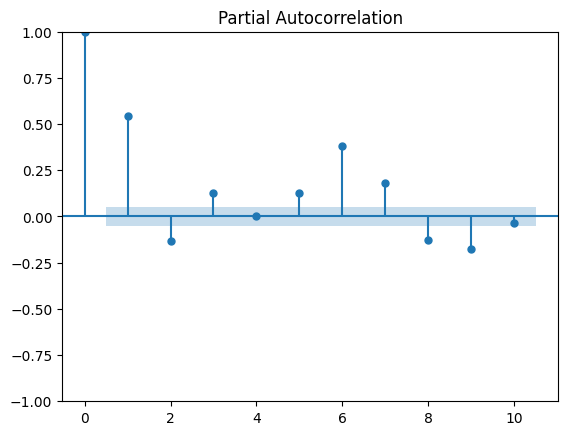

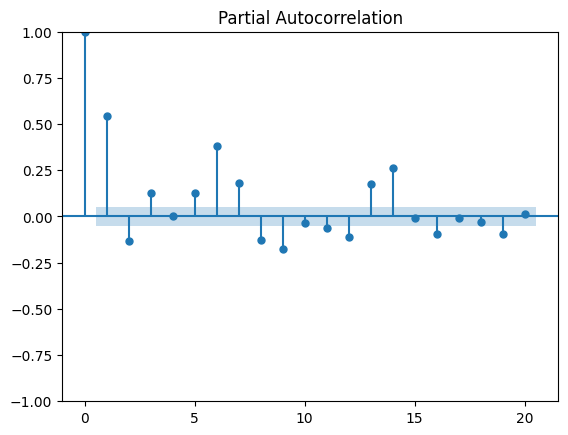

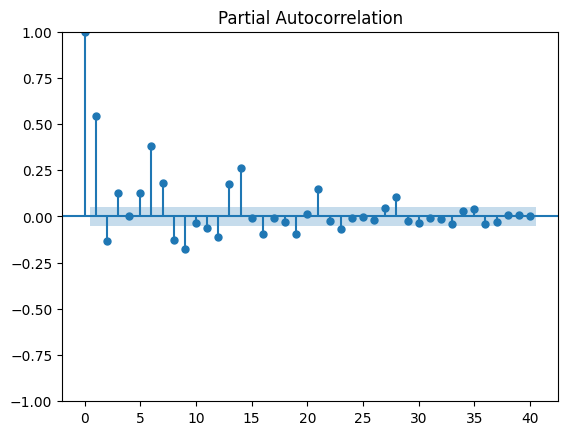

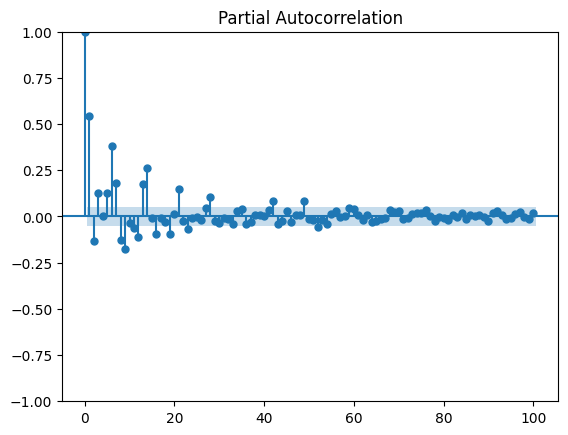

In [6]:
pacf_original_10 = plot_pacf(df, lags = 10)
pacf_original_20 = plot_pacf(df, lags = 20)
pacf_original_40 = plot_pacf(df, lags = 40)
pacf_original_100 = plot_pacf(df, lags = 100)

#### ADF Test

- The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine if a time series is stationary. It tests the null hypothesis that a unit root is present in the time series -> the series is non-stationary.
- The p-value helps determine the significance of the results. A low p-value (typically less than 0.05) indicates that you can reject the null hypothesis

In [7]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df)
print('ADF Statistic:', adf_test[0]) # A more negative value -> stronger evidence against the null hypothesis -> time series is stationary
print(f'p-value: {adf_test[1]}')
print('Critical Values:')
for key, value in adf_test[4].items(): 
    print(f'   {key}: {value}')

ADF Statistic: -4.674166174588261
p-value: 9.407649467775781e-05
Critical Values:
   1%: -3.4349247631306237
   5%: -2.8635604442944658
   10%: -2.5678456715029183


### Split dataset to train and test

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2013-01-01 to 2015-12-31
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   transactions  1092 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2016-01-02 to 2016-12-31
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   transactions  363 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


<Axes: xlabel='date'>

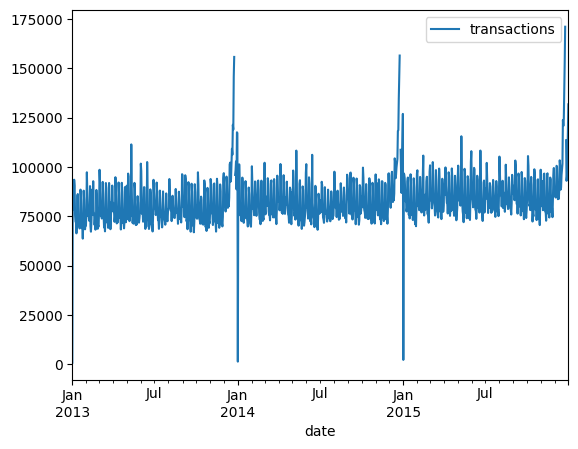

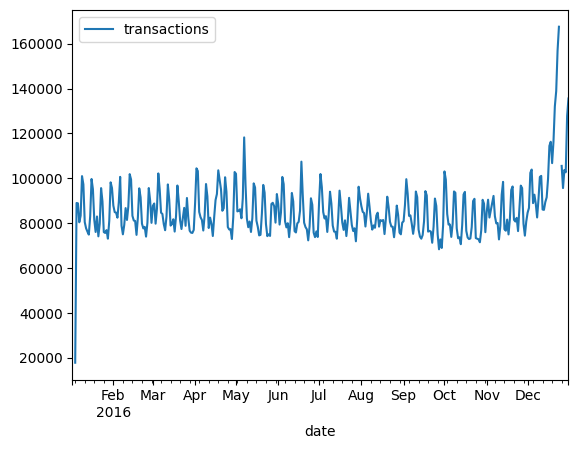

In [8]:
train = df.loc[df.index < '01-01-2016']
train.index = pd.to_datetime(train.index, format='%d-%m-%Y')
train = train.asfreq('D')

test = df.loc[df.index >= '01-01-2016']
test.index = pd.to_datetime(test.index, format='%d-%m-%Y')
test = test.asfreq('D')

train.info()
test.info()

train.plot()
test.plot()

# train = df
# train.index = pd.to_datetime(train.index, format='%d-%m-%Y')
# train = train.asfreq('D')

### Step 3: Check train and test datasets

- Interpolation is a method of estimating unknown values that fall between known values. When you have a time series with missing data points, interpolation helps in filling those gaps by using the surrounding data points
- The method='time' argument specifies that the interpolation should be done according to the time index. This means the missing values are estimated based on the time sequence of the data.

In [9]:
has_nan = train.isna().any().any()
print("Does the DataFrame have any NaN values? ", has_nan)

has_nan = train.isna().any().any()
print("Does the DataFrame have any NaN values? ", has_nan)

train_interpolated_time = train.interpolate(method='time')
test_interpolated_time = test.interpolate(method='time')

has_nan = train_interpolated_time.isna().any().any()
print("Does the DataFrame have any NaN values? ", has_nan)

has_nan = test_interpolated_time.isna().any().any()
print("Does the DataFrame have any NaN values? ", has_nan)

Does the DataFrame have any NaN values?  True
Does the DataFrame have any NaN values?  True
Does the DataFrame have any NaN values?  False
Does the DataFrame have any NaN values?  False


### Step 4: Fit ARIMA model

In [10]:
### Fit the ARIMA model

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_interpolated_time['transactions'], order=(20,0,10))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\ira\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ira\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ira\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           transactions   No. Observations:                 1095
Model:               ARIMA(20, 0, 10)   Log Likelihood              -11387.726
Date:                Tue, 02 Jul 2024   AIC                          22839.452
Time:                        15:41:39   BIC                          22999.405
Sample:                    01-01-2013   HQIC                         22899.977
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.295e+04   1922.256     43.151      0.000    7.92e+04    8.67e+04
ar.L1          0.0237      2.528      0.009      0.993      -4.931       4.978
ar.L2          0.1191      1.759      0.068      0.9

### Make sure that model captured adequate inforamtion

- if model is good residulas should look like noise

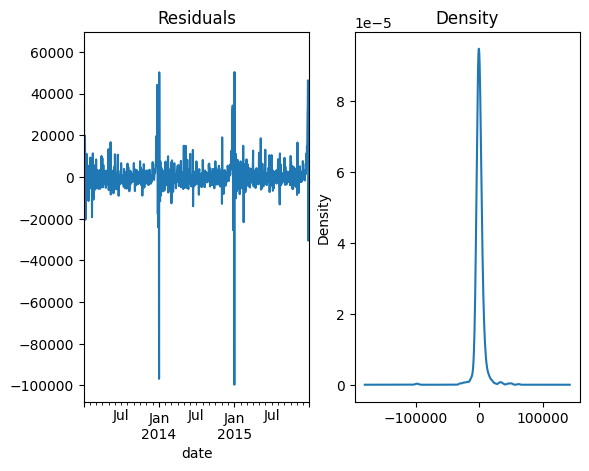

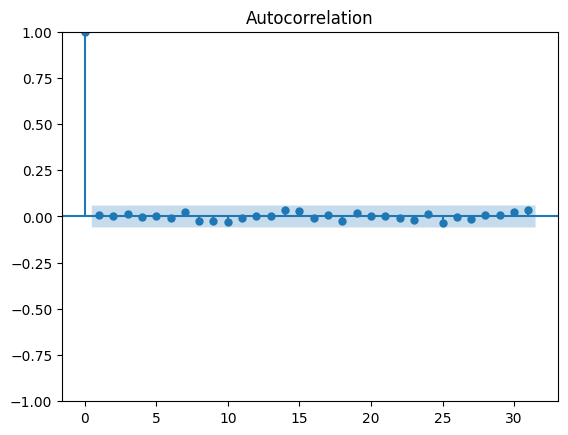

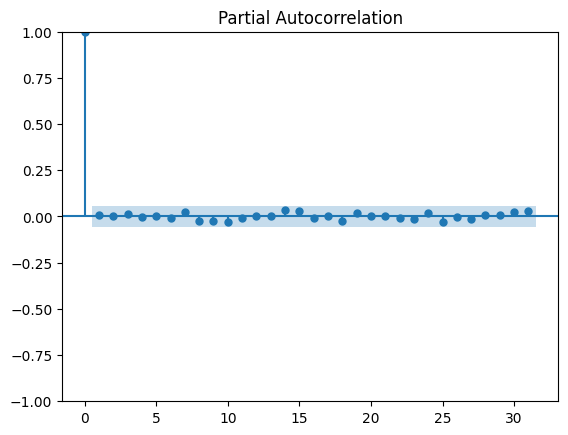

In [11]:
#import matplotlib.pyplot as plt

residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title= 'Residuals', ax=ax[0])
residuals.plot(title= 'Density', kind='kde', ax=ax[1])
plt.show()

acf_orginal = plot_acf(residuals)
pacf_original = plot_pacf(residuals)

### Forecasting

<class 'pandas.core.series.Series'>
DatetimeIndex: 365 entries, 2016-01-01 to 2016-12-30
Freq: D
Series name: predicted_mean
Non-Null Count  Dtype  
--------------  -----  
365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


<Axes: xlabel='date'>

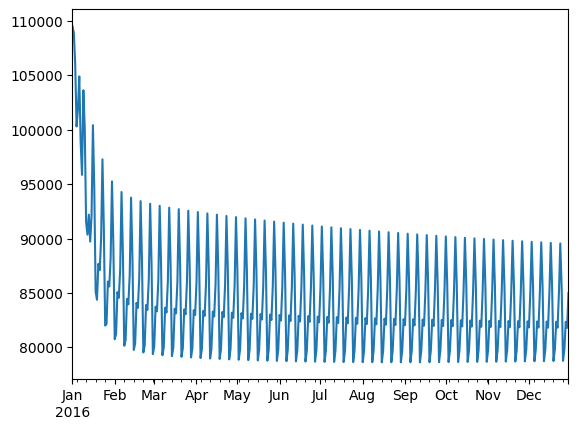

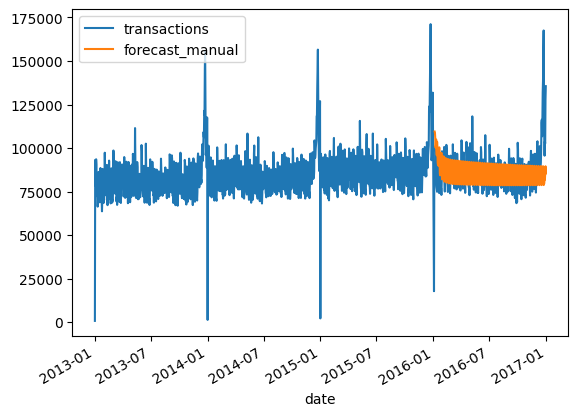

In [12]:
forecast_test = model_fit.forecast(len(test_interpolated_time))
forecast_test.info()
forecast_test.head()
forecast_test.tail()

forecast_test.plot()

df['forecast_manual'] = [None]*len(train_interpolated_time)+list(forecast_test[:len(forecast_test)-5])
df.plot()

### Auto-fit the ARIMA model

In [17]:
import pmdarima as pm

auto_arima = pm.auto_arima(train_interpolated_time, stepwise = False)
auto_arima
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1095
Model:               SARIMAX(2, 1, 3)   Log Likelihood              -11558.612
Date:                Tue, 02 Jul 2024   AIC                          23131.224
Time:                        15:50:16   BIC                          23166.208
Sample:                    01-01-2013   HQIC                         23144.462
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    110.4284     82.410      1.340      0.180     -51.093     271.950
ar.L1          1.2458      0.003    416.145      0.000       1.240       1.252
ar.L2         -0.9969      0.001   -814.795      0.000      -0.999      -0.995
ma.L1         -1.8979      0.013   -141.942      0.000      -1.924      -1.872
ma.L2          1.7719      0.020     87.022      0.000       1.732       1.812
ma.L3         -0.6397      0.014    -45.005      0.000      -0.668      -0.612
sigma2      9.372e+07      0.001   9.75e+10      0.000    9.37e+07    9.37e+07
===================================================================================
Ljung-Box (L1) (Q):                  16.18   Jarque-Bera (JB):             58286.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -1.92
Prob(H) (two-sided):                  0.23   Kurtosis:                        38.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.51e+25. Standard errors may be unstable.
"""

### Autoarima forecast

<class 'pandas.core.series.Series'>
DatetimeIndex: 365 entries, 2016-01-01 to 2016-12-30
Freq: D
Series name: None
Non-Null Count  Dtype  
--------------  -----  
365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


<Axes: xlabel='date'>

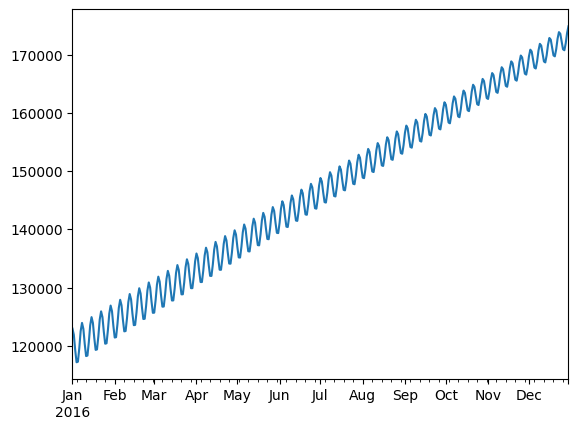

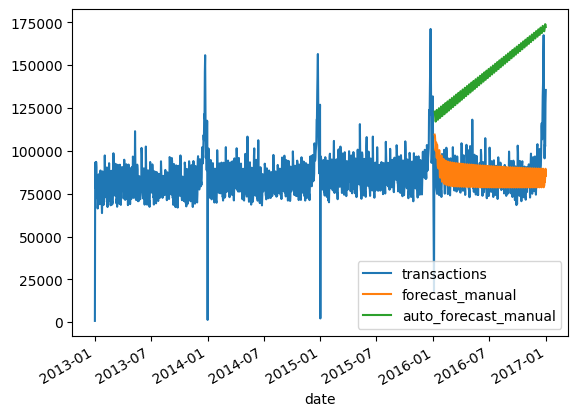

In [18]:
auto_forecast_test = auto_arima.predict(n_periods=len(test_interpolated_time))
auto_forecast_test.info()
auto_forecast_test.head()
auto_forecast_test.tail()

auto_forecast_test.plot()

df['auto_forecast_manual'] = [None]*len(train_interpolated_time)+list(auto_forecast_test[:len(auto_forecast_test)-5])
df.plot()

In [21]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(test_interpolated_time, forecast_test) # koliko su predikcije modela u proseku udaljene od stvarnih vrednosti
mape = mean_absolute_percentage_error(test_interpolated_time, forecast_test) # izražava grešku u procentima
rmse = np.sqrt (mean_squared_error(test_interpolated_time, forecast_test)) # prosečna kvadratna greška između predikovanih i stvarnih vrednosti
print (f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 7973.363414749861
mape - manual: 0.10004523880559109
rmse - manual: 13339.299979736234


### Predict for 2017

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    227 non-null    object
 1   id      227 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ KB
           date   id
0    01-01-2017    0
1    02-01-2017    1
2    03-01-2017    2
3    04-01-2017    3
4    05-01-2017    4
..          ...  ...
222  11-08-2017  222
223  12-08-2017  223
224  13-08-2017  224
225  14-08-2017  225
226  15-08-2017  226

[227 rows x 2 columns]
Does the DataFrame have any NaN values?  False
2017-01-01    112961.403575
2017-01-02     89134.460651
2017-01-03     87803.501117
2017-01-04     95647.990077
2017-01-05     99896.811586
                  ...      
2017-08-11     83649.516092
2017-08-12     92924.550293
2017-08-13     87987.954646
2017-08-14     78983.484411
2017-08-15     81056.768906
Freq: D, Name: predicted_mean, Length: 227, dtype: float64


Text(0, 0.5, 'Transactions')

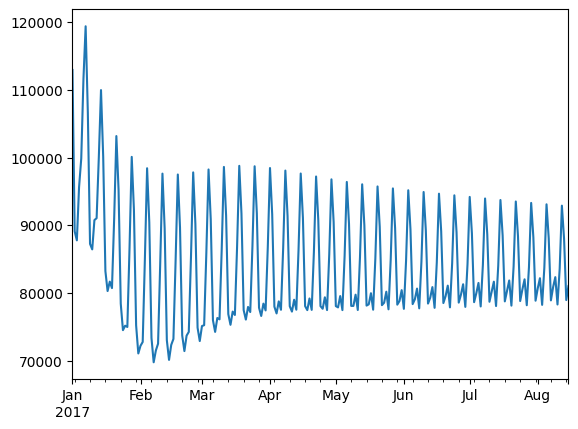

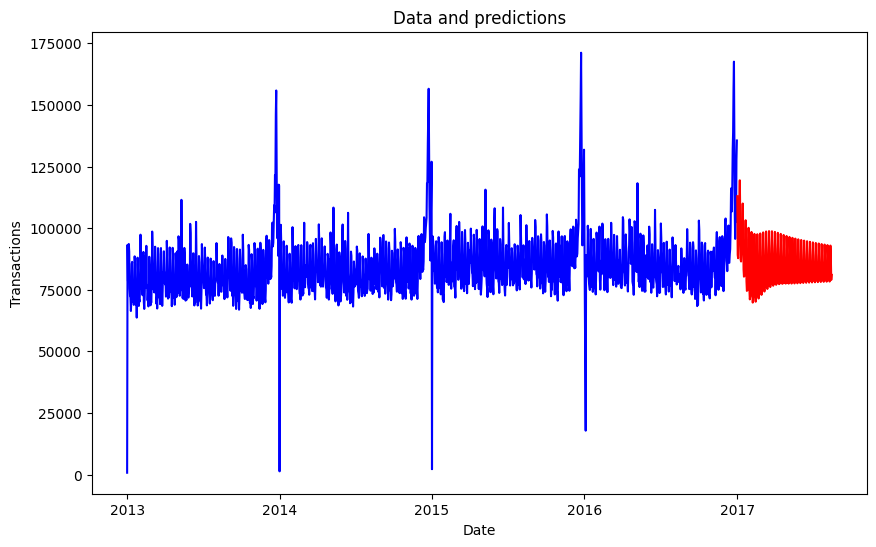

In [68]:
df_test = pd.read_csv('test.csv')
df_test.info()
print(df_test)

df_test = df_test.set_index('date')
df_test.index = pd.to_datetime(df_test.index, format='%d-%m-%Y')

has_nan = df_test.isna().any().any()
print("Does the DataFrame have any NaN values? ", has_nan)

forecast_df_test = model_fit.forecast(len(df_test))
print(forecast_df_test)

forecast_df_test.plot()

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['transactions'], label='Train set', color='blue')
plt.plot(forecast_df_test.index, forecast_df_test, label='Forecast', color='red')

plt.title('Data and predictions')
plt.xlabel('Date')
plt.ylabel('Transactions')
